# Authorship of the Federalist Papers

The _Federalist Papers_ were a set of 85 essays published between 1787 and 1788 to promote the ratification of the United States Constitution. They were originally published under the pseudonym "Publius". Although the identity of the authors was a closely guarded secret at the time, most of the papers have since been conclusively attributed to one of Hamilton, Jay, or Madison. The known authorships can be found in `https://dlsun.github.io/pods/data/federalist/authorship.csv`.

For 15 of the papers, however, the authorships remain disputed. (These papers can be identified from the `authorship.csv` file because the "Author" field is blank.) In this analysis, I will use the papers with known authorship to predict the authorships of the disputed papers. The text of each paper is available at `https://dlsun.github.io/pods/data/federalist/x.txt`, where `x` is the number of the paper (i.e., a number from 1 to 85). The name of the file indicates the number of the paper.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import requests
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv").set_index("Paper")

fedPapers = pd.Series()
for file in range(1, 86):
  response = requests.get("https://dlsun.github.io/pods/data/federalist/%d.txt" % file, "r")
  fedPapers[str(file)] = response.text
fedPapers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


1     To the People of the State of New York:\n\nAFT...
2     To the People of the State of New York:\n\nWHE...
3     To the People of the State of New York:\n\nIT ...
4     To the People of the State of New York:\n\nMY ...
5     To the People of the State of New York:\n\nQUE...
                            ...                        
81    To the People of the State of New York:\n\nLET...
82    To the People of the State of New York:\n\nTHE...
83    To the People of the State of New York:\n\nTHE...
84    To the People of the State of New York:\n\nIN ...
85    To the People of the State of New York:\n\nACC...
Length: 85, dtype: object

When analyzing an author's style, common words like "the" and "on" are actually more useful than rare words like "hostilities". That is because rare words typically signify context. Context is useful if you are trying to find documents about similar topics, but not so useful if you are trying to identify an author's style because different authors can write about the same topic.

In [ ]:
vec = CountVectorizer(max_features = 50)
vec.fit(fedPapers)
tf_sparse = vec.transform(fedPapers)

fedPaperWords = pd.concat([pd.DataFrame(tf_sparse.todense(), columns=vec.get_feature_names()), df.reset_index()], axis=1).set_index("Paper")
fedPaperWords

,all,an,and,any,are,as,at,be,been,but,by,can,constitution,for,from,government,has,have,if,in,is,it,its,may,more,no,not,of,on,one,or,other,people,power,state,states,than,that,the,their,them,they,this,those,to,we,which,will,with,would,Author
Paper,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9,11,40,6,12,10,8,34,3,2,14,3,8,12,11,9,6,10,4,27,13,20,10,11,7,3,14,106,9,4,6,3,6,2,6,2,11,28,133,14,2,6,14,9,72,8,18,25,6,2,Hamilton
2,4,1,83,1,6,16,10,15,8,8,10,0,0,13,4,9,6,17,3,34,16,38,5,4,5,1,10,83,8,10,10,4,23,1,1,2,5,44,107,21,4,22,14,2,53,5,11,2,13,5,Jay
3,4,3,60,5,8,24,1,31,2,7,18,3,0,11,15,16,5,7,7,25,7,21,1,6,13,2,13,62,6,8,32,7,8,3,8,11,8,20,93,11,8,5,6,6,56,0,11,24,10,2,Jay
4,4,3,90,5,11,20,2,26,2,10,14,8,0,12,8,16,1,9,14,24,10,28,9,10,13,1,14,72,11,13,24,11,8,2,6,1,9,17,86,19,12,17,1,4,51,10,10,15,12,17,Jay
5,4,4,72,3,3,3,4,31,0,4,10,1,0,7,11,2,0,1,3,28,7,21,4,2,11,2,8,53,5,10,10,4,3,1,2,1,9,23,66,11,11,11,6,9,45,5,10,7,11,37,Jay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,13,22,88,15,15,46,7,85,22,20,32,6,13,21,20,7,12,23,6,135,61,65,10,25,4,8,26,248,16,10,21,6,1,20,26,18,6,49,389,11,16,11,44,12,163,2,41,30,14,21,Hamilton
82,7,10,41,1,11,15,2,36,1,4,4,5,4,4,14,3,0,7,2,38,15,13,4,14,1,4,13,94,0,9,13,2,1,10,18,8,3,19,168,6,4,10,14,6,83,2,18,7,6,11,Hamilton
83,28,20,121,16,43,54,19,105,36,25,82,6,13,39,22,16,22,54,24,213,116,102,21,16,23,22,36,331,18,18,26,21,3,10,33,23,16,121,485,16,21,29,60,13,219,5,79,24,30,48,Hamilton


A visualization that summarizes the most common words used by Hamilton, Madison, and Jay.

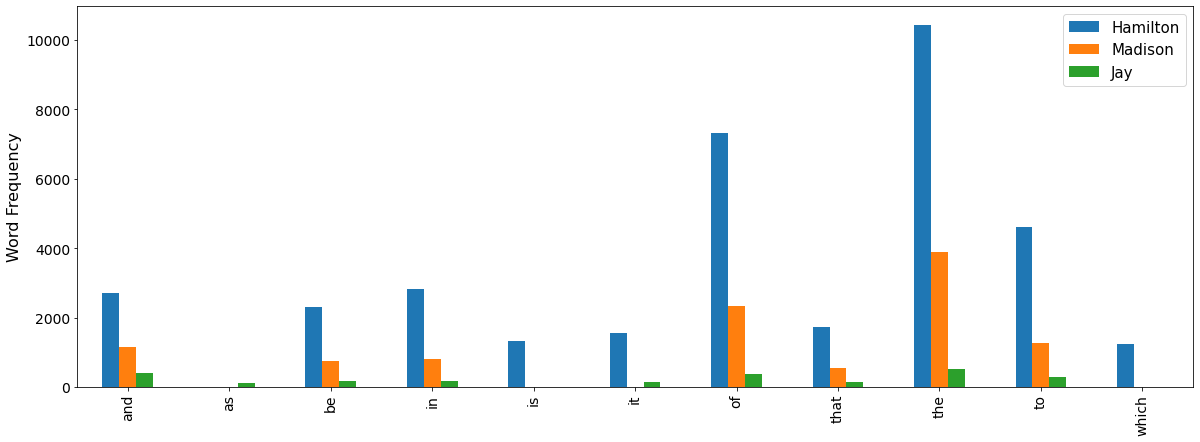

In [ ]:
import matplotlib
HamiltonWords = fedPaperWords.groupby("Author").sum().loc["Hamilton"].where(lambda x : x > 1000).dropna().to_frame()
MadisonWords = fedPaperWords.groupby("Author").sum().loc["Madison"].where(lambda x : x > 500).dropna().to_frame()
JayWords = fedPaperWords.groupby("Author").sum().loc["Jay"].where(lambda x : x > 100).dropna().to_frame()
# merge the 3 series with the author names, groupby the author names and graph 
mostCommon = HamiltonWords.merge(MadisonWords, left_index=True, right_index=True, how="outer").merge(JayWords, left_index=True, right_index=True, how="outer")

mostCommon.plot.bar(figsize=(20, 7), ylabel="Word Frequency", fontsize=14)

axes = matplotlib.pyplot.gca()
axes.yaxis.label.set_size(16)
matplotlib.pyplot.legend(prop={"size":15})

For each of the documents with disputed authorships, find the 5 most similar documents with _known_ authorships, using cosine distance on the term frequencies. Use the authors of these 5 most similar documents to predict the author of each disputed document. 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv")

# creates sparse matrix
vec = CountVectorizer(max_features = 50)
vec.fit(fedPapers)
tf_sparse = vec.transform(fedPapers)

# subest the unkown papers
unknown_papers = df[df.Author.isnull()]

# creates a new dataframe using the unknown papers as columns and their cosine similarity values as datapoints
# there are 85 rows representing each paper.
cos_unknown = pd.DataFrame(cosine_similarity(tf_sparse)[unknown_papers.index]).T 
cos_unknown.columns = [str(x) for x in unknown_papers.index +1]
cos_unknown["Author"] = df.Author

# takes out NA authors
cos_unknown.dropna(inplace=True)

# iterates through each column
# takes the 5 largest values
# gets index
# used Counter to find the most common author of those top 5 papers
# returns the unkown paper number and the predicted author
for column in cos_unknown[cos_unknown.columns[0:15]]:
  indeces = cos_unknown[column].nlargest(5).index
  print(column, Counter(cos_unknown.loc[indeces].Author).most_common()[0][0])

18 Madison
19 Madison
20 Madison
49 Hamilton
50 Madison
51 Madison
52 Hamilton
53 Madison
54 Madison
55 Hamilton
56 Hamilton
57 Madison
58 Madison
62 Hamilton
63 Madison


**This output matches the wikepedia list except for 49, 52, 55, 56, and 62**